In [150]:
import pandas as pd
import pydeck as pdk
import networkx as nx
import matplotlib.pyplot as plt
from utils.cflp_function import *
from utils.calculate_od import *
from pysal.lib import weights
from pysal.explore import esda
import gc
import seaborn as sns
from IPython.display import display, HTML

load_hex_data(file_path): This function loads hexagonal data from a CSV file located at file_path and returns a pandas DataFrame.

In [151]:
def load_hex_data(file_path):
    """Loads hexagonal data from a CSV file."""
    return pd.read_csv(file_path)

create_map_layer(hex_data, longitude, latitude, zoom): This function creates a map layer of hexagons using the provided hexagonal data. The map is centered at the provided longitude and latitude, and the zoom level is set to the provided value.

In [152]:
def create_map_layer(hex_data, longitude, latitude, zoom):
    """Creates a map layer of hexagons."""
    layer = pdk.Layer(
        "H3HexagonLayer",
        hex_data,
        pickable=True,
        filled=True,
        extruded=False,
        auto_highlight=True,
        opacity=0.6,
        get_hexagon="hex9",
        get_fill_color = 'color', 
        get_line_color=[255, 255, 255],
        line_width_min_pixels=0.1
    )
    
    # Set the viewport location
    view_state = pdk.ViewState(longitude=longitude, latitude=latitude, zoom=zoom, bearing=0, pitch=0)
    
    # Create the deck
    deck = pdk.Deck(layers=[layer], initial_view_state=view_state, tooltip={"text": "Value: {fuzzy}"})
    
    return deck

render_map(deck, map_name): This function renders a map with the specified layer (deck) and saves it as an HTML file with the name map_name.

In [153]:
def render_map(deck, map_name):
    """Renders a map with the specified layer."""
    map_html = deck.to_html(map_name, notebook_display=True)
    
    # Display the map in a Jupyter notebook
    display(map_html)

load_h3_polygons(file_path): This function loads H3 polygon data from a shapefile located at file_path and returns a GeoDataFrame.

In [154]:
def load_h3_polygons(file_path):
    """Loads H3 polygon data from a shapefile."""
    idx = gpd.read_file(file_path)
    return idx.set_index('hex9')

In [155]:
def compute_spatial_weights(df):
    """Computes spatial weights."""
    w = weights.Queen.from_dataframe(df, use_index=True)
    w.transform = 'R'  # Row standardize the matrix
    return w

In [156]:
def merge_data(idx, hex_data):
    """Merges compound suitability map and H3 geometry information."""
    hex_df = idx.merge(hex_data[['hex9','color','fuzzy']], on='hex9',how='left')
    hex_df['fuzzy_std'] = (hex_df['fuzzy'] - hex_df['fuzzy'].mean()) / hex_df['fuzzy'].std()
    hex_df['lag_std'] = weights.lag_spatial(w, hex_df['fuzzy_std'])
    hex_df['lag'] = weights.lag_spatial(w, hex_df['fuzzy'])
    return hex_df

In [157]:
def compute_local_moran(hex_df, w):
    """Computes local Moran's I."""
    lisa = esda.Moran_Local(hex_df['fuzzy'], w, seed=42)
    return lisa

In [158]:
def create_graph(w):
    """Creates a graph from the weights matrix."""
    w.transform = 'B'
    g = w.to_networkx()
    mapping = {new_index: old_index for new_index, old_index in enumerate(w.id_order)}
    g = nx.relabel_nodes(g, mapping)
    return g


In [159]:
def get_subgraph(g, hex_df, significant_001, quadrant):
    """Gets a subgraph that includes only the HH quadrant."""
    hh = hex_df[(significant_001 == True) & (quadrant == 1)].hex9.to_list()
    h = g.subgraph(hh)
    return h

In [160]:
def get_connected_components(h):
    """Gets connected components in the sub graphs."""
    subh = list(nx.connected_components(h))
    filter_subh = [component for component in subh if len(component) > 10]
    return filter_subh

In [161]:
def calculate_eigenvector_centrality(filter_subh, h):
    """Calculates eigenvector centrality for each connected component."""
    eigenvector_centralities = []
    for component in filter_subh:
        subgraph = h.subgraph(component)
        eigenvector_centrality = nx.eigenvector_centrality(subgraph, max_iter=1000)
        eigenvector_centralities.append(eigenvector_centrality)
    return eigenvector_centralities

In [162]:
def identify_sites(eigenvector_centralities):
    """Identifies sites."""
    site = []
    for centrality_dict in eigenvector_centralities:
        max_node_index = max(centrality_dict, key=centrality_dict.get)
        site.append(max_node_index)
    return site

In [163]:
def visualize_eigenvector_centrality(eigenvector_centralities):
    """Visualizes the Eigenvector Centrality with KDE."""
    plt.figure(figsize=(10, 6))
    sns.histplot([centrality for subgraph in eigenvector_centralities for centrality in subgraph.values()], bins=30, kde=True)
    plt.title('Histogram of Eigenvector Centrality')
    plt.xlabel('Eigenvector Centrality')
    plt.ylabel('Frequency')
    plt.show()


In [164]:
def visualize_fuzzy_values(hex_df):
    """Visualizes the Fuzzy Values with KDE."""
    plt.figure(figsize=(10, 6))
    sns.histplot(hex_df['fuzzy'].dropna(), bins=30, kde=True)
    plt.title('Histogram of Fuzzy Values')
    plt.xlabel('Fuzzy Value')
    plt.ylabel('Frequency')
    plt.show()


In [165]:
def visualize_spatial_lag_vs_fuzzy_values(hex_df):
    """Visualizes the Scatter Plot of Spatial Lag vs Fuzzy Values with regression line."""
    plt.figure(figsize=(10, 6))
    sns.regplot(x=hex_df['fuzzy'], y=hex_df['lag'])
    plt.title('Scatter Plot of Spatial Lag vs Fuzzy Values')
    plt.xlabel('Fuzzy Value')
    plt.ylabel('Spatial Lag')
    plt.show()

In [166]:
def main():
    hex = load_hex_data('./hex/hex_df2.csv')
    deck = create_map_layer(hex, longitude=4.390, latitude=51.891, zoom=6)
    render_map(deck, "layer.html")
    idx = load_h3_polygons('app_data/h3_polygons.shp')
    w = compute_spatial_weights(idx)
    hex_df = merge_data(idx, hex)
    lisa = compute_local_moran(hex_df, w)
    significant_001 = lisa.p_sim < 0.01
    quadrant = lisa.q
    g = create_graph(w)
    h = get_subgraph(g, hex_df, significant_001, quadrant)
    filter_subh = get_connected_components(h)
    eigenvector_centralities = calculate_eigenvector_centrality(filter_subh, h)
    site = identify_sites(eigenvector_centralities)
    visualize_eigenvector_centrality(eigenvector_centralities)
    visualize_fuzzy_values(hex_df)
    visualize_spatial_lag_vs_fuzzy_values(hex_df)
    gc.collect()

/home/vscode/.local/lib/python3.11/site-packages/libpysal/weights/contiguity.py:347: UserWarning: The weights matrix is not fully connected: 
 There are 8 disconnected components.
 There are 2 islands with ids: 891f16c693bffff, 891f1610e8fffff.
  W.__init__(self, neighbors, ids=ids, **kw)


('WARNING: ', '891f16c693bffff', ' is an island (no neighbors)')
('WARNING: ', '891f1610e8fffff', ' is an island (no neighbors)')


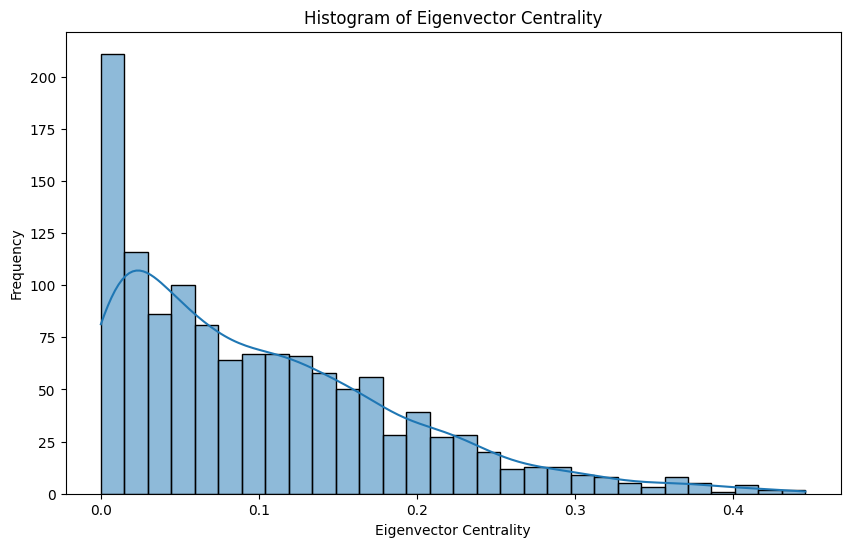

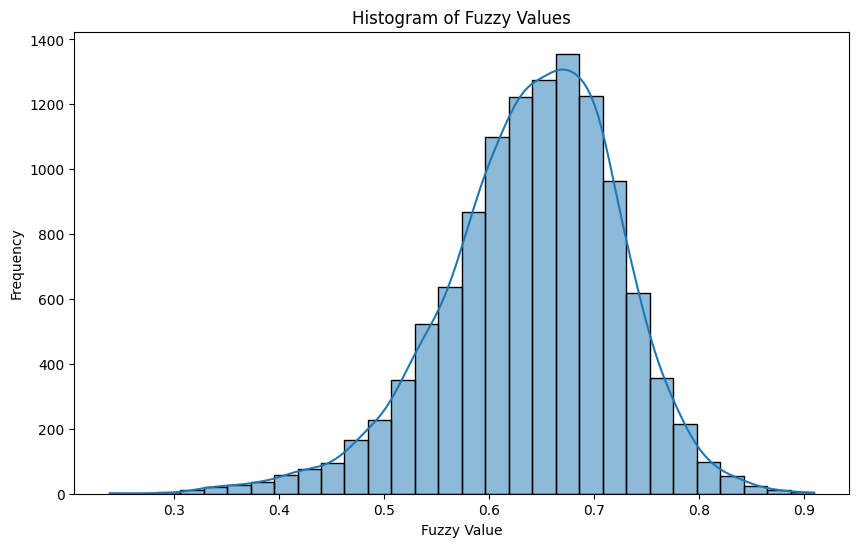

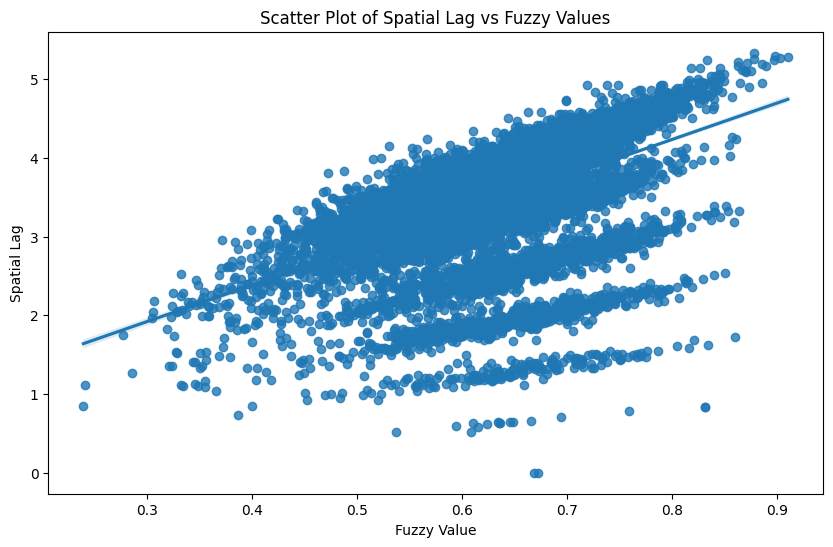

In [167]:
if __name__ == "__main__":
    main()